In [108]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scoring as sc
import scheduler as sch
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
# read json file patient_config.json
with open('patient_config.json') as f:
    patient_config = json.load(f)
    print(patient_config)
search_from = sch.search_from_dose(patient_config)
doses1 = [1, 0.75, 0.5] if search_from <= 1 else [float(patient_config["d1"])]
doses2 = [1, 0.75, 0.5] if search_from <= 2 else [float(patient_config["d2"])]
doses3 = [1, 0.75, 0.5] if search_from <= 3 else [float(patient_config["d3"])]
doses4 = [1, 0.75, 0.5] if search_from <= 4 else [float(patient_config["d4"])]
plans = [(t1, t2, t3, t4) for t1 in doses1 for t2 in doses2 for t3 in doses3 for t4 in doses4]

{'toxicity': 0.0, 'burden': 10000000000.0, 'a': 239.37137232938915, 's1': 0.11001677779299837, 's2': 0.07830565181568241, 's3': 0.058557845056986135, 's4': 0.01860218612399429, 'tx1': 0.020865062615215327, 'tx2': 0.014119686573147638, 'tx3': 0.009926773308534408, 'tx4': 0.0025963083477064846, 'start_strike': 1, 'start_cycle': 1, 'r': 0.95}


In [110]:
start_time = time.time()
print(f"Testing {len(plans)} treatment schedules.")

patient_config["tx1"] = 0.01
patient_config["tx2"] = 0.01
patient_config["tx3"] = 0.01
patient_config["tx4"] = 0.01

sols = [sc.score(patient_config, plan) for plan in plans]
sols = [sol for sol in sols if sol is not None]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Found {len(sols)} feasible treatment schedules.")
print(f"Elapsed Time: {elapsed_time:.4f} seconds")

Testing 81 treatment schedules.
Found 81 feasible treatment schedules.
Elapsed Time: 55.2078 seconds


In [111]:
scored_plans = [[*sol["plan"], sc.score_burden(sol["burden_sol"]), sc.score_toxicity(sol["toxicity_sol"]), sch.duration(sol["schedule"])] for sol in sols]
df_sp = pd.DataFrame(scored_plans, columns = ["S1", "S2", "S3", "S4", "burden", "toxicity", "total_time"])
df_sp["total_time"] = df_sp["total_time"].astype(int)
df_sp.head()

,S1,S2,S3,S4,burden,toxicity,total_time
0,1.0,1.0,1.00,1.00,0.481646,0.141899,413
1,1.0,1.0,1.00,0.75,0.924660,0.129126,413
2,1.0,1.0,1.00,0.50,1.776064,0.117825,413
3,1.0,1.0,0.75,1.00,2.400865,0.129522,413
4,1.0,1.0,0.75,0.75,4.629426,0.117094,413


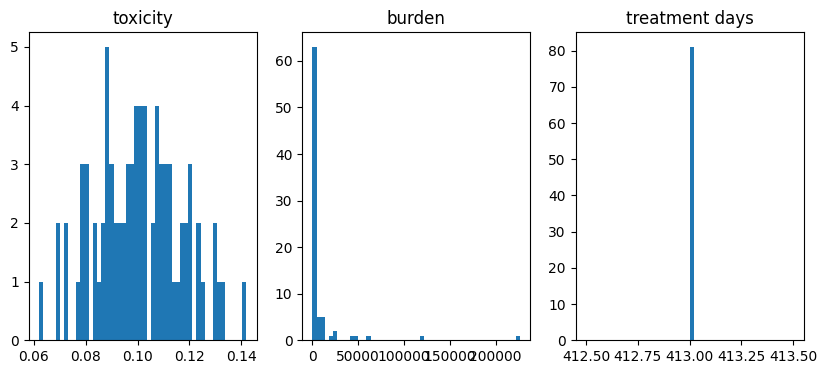

In [112]:
# plot two histograms for cost and benefit
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist(df_sp["toxicity"], bins=50)
ax[0].set_title("toxicity");
ax[1].hist(df_sp["burden"], bins=50)
ax[1].set_title("burden");
ax[2].hist(df_sp["total_time"], bins=50)
ax[2].set_title("treatment days");

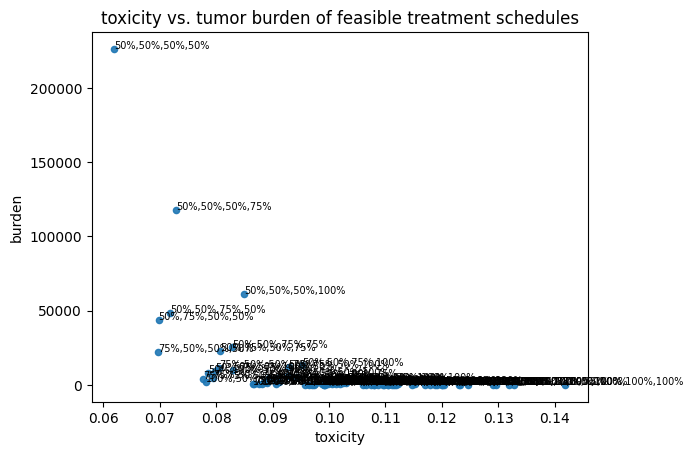

In [120]:
plt.scatter(df_sp["toxicity"], df_sp["burden"], s=20, alpha=0.9)

# Add compact labels
# for i in range(df_sp.shape[0]):
#     values = df_sp.iloc[i][['S1','S2','S3','S4']].values
#     label = f"{values[0]:2.0%},{values[1]:2.0%},{values[2]:2.0%},{values[3]:2.0%}"
#     plt.text(df_sp.iloc[i]["toxicity"], df_sp.iloc[i]["burden"], label, fontsize=7)

# set y to log
plt.xlabel("toxicity")
plt.ylabel("burden")
plt.title("toxicity vs. tumor burden days of feasible treatment schedules");
plt.savefig("treatments.png")

In [124]:
time_min = df_sp["toxicity"].min()
time_max = df_sp["toxicity"].max()
time_range = time_max - time_min
df_sp["toxicity_score"] = 1 - (df_sp["toxicity"] - time_min) / time_range

burden_min = df_sp["burden"].min()
burden_max = df_sp["burden"].max()
burden_range = burden_max - burden_min
df_sp["burden_score"] = 1 - (df_sp["burden"] - burden_min) / burden_range

df_sp["score"] = df_sp["toxicity_score"] + df_sp["burden_score"]
df_sp

,S1,S2,S3,S4,burden,toxicity,total_time,time_score,burden_score,score,toxicity_score
0,1.0,1.0,1.00,1.00,0.481646,0.141899,413,NaN,1.000000,1.000000,0.000000
1,1.0,1.0,1.00,0.75,0.924660,0.129126,413,NaN,0.999998,1.159782,0.159784
2,1.0,1.0,1.00,0.50,1.776064,0.117825,413,NaN,0.999994,1.301134,0.301140
3,1.0,1.0,0.75,1.00,2.400865,0.129522,413,NaN,0.999992,1.154811,0.154820
4,1.0,1.0,0.75,0.75,4.629426,0.117094,413,NaN,0.999982,1.310265,0.310283
...,...,...,...,...,...,...,...,...,...,...,...
76,0.5,0.5,0.75,0.75,25310.212371,0.082829,413,NaN,0.888159,1.627070,0.738911
77,0.5,0.5,0.75,0.50,48570.982895,0.071792,413,NaN,0.785373,1.662342,0.876969
78,0.5,0.5,0.50,1.00,61531.071633,0.084989,413,NaN,0.728104,1.439984,0.711880
79,0.5,0.5,0.50,0.75,118017.598687,0.072815,413,NaN,0.478497,1.342668,0.864172


In [125]:
df_sp.iloc[df_sp["score"].idxmax()]

S1                    0.750000
S2                    0.500000
S3                    0.500000
S4                    0.500000
burden            22367.815371
toxicity              0.069642
total_time          413.000000
time_score                 NaN
burden_score          0.901161
score                 1.805029
toxicity_score        0.903867
Name: 53, dtype: float64

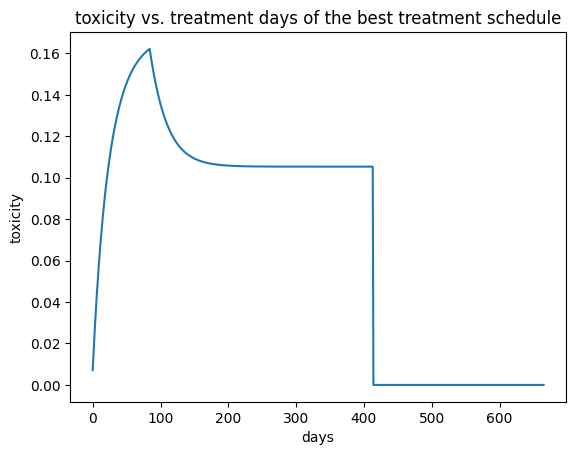

In [126]:
best_solution = sols[df_sp["score"].idxmax()]
plt.plot(best_solution["toxicity_sol"]);
plt.xlabel("days")
plt.ylabel("toxicity")
plt.title("toxicity vs. treatment days of the best treatment schedule");
plt.savefig("toxicity.png")

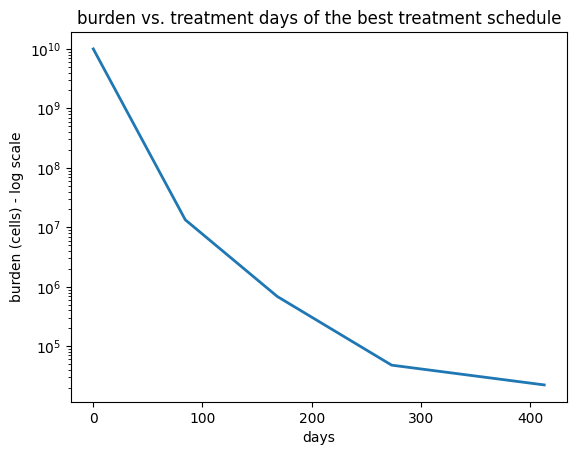

In [127]:
sol = best_solution["burden_sol"]
plt.plot(sol .t, sol .y.T[:, 0], lw=2);
plt.xlabel("days")
plt.ylabel("burden (cells) - log scale")
plt.yscale("log")
plt.title("burden vs. treatment days of the best treatment schedule");
plt.savefig("burden.png")

In [128]:
import file_manipulation as fm
cyc_df = fm.cycles_to_df(best_solution["schedule"])
report = fm.cycles_df_to_report(cyc_df)
sch_df = fm.report_to_df(report)
sch_df.to_csv("schedule.csv", index=False)
sch_df

,strike,dose,days
0,1,0.75,21
1,1,0.75,21
2,1,0.75,21
3,1,0.75,21
4,2,0.5,21
5,2,0.5,21
6,2,0.5,21
7,2,0.5,21
8,3,0.5,21
9,3,0.5,21


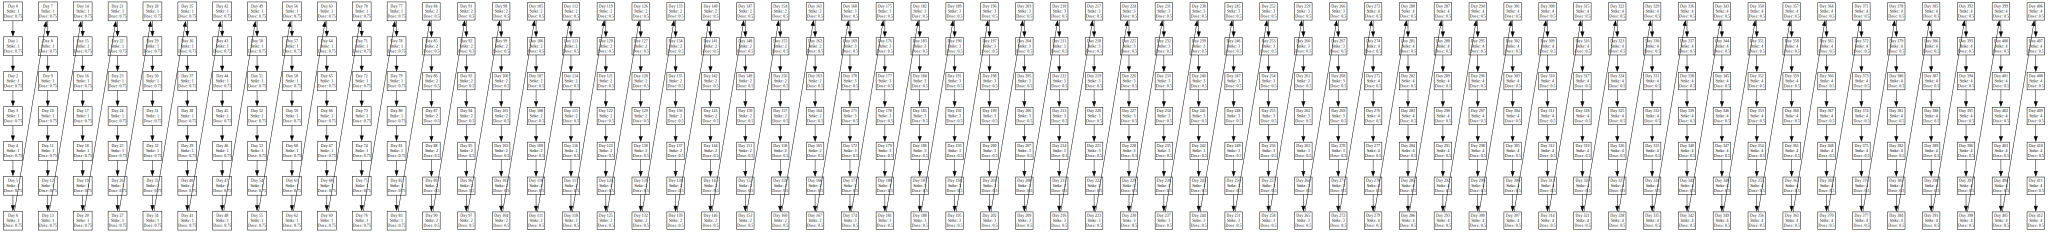

In [130]:
import visualization as vis
vis.create_graph(sch_df)